# Studi Kasus dan Analisis Masalah

Studi kasus yang digunakan adalah kasus knapsack dengan jumlah barang sebanyak 23 item yang masing-masingnya memiliki `price` dan `weight` yang berbeda. Data didapatkan dari dataset pada link berikut: http://artemisa.unicauca.edu.co/~johnyortega/instances_01_KP/. Dari studi kasus diatas, akan dipilih barang dengan _weight_ tidak lebih dari 10.000 (kg) dengan memaksimalkan _cost_ (dalam hal ini _price_) yang didapat. 

# Metode dan Desain Individu

Dalam Tugas 3 kali ini, masalah diselesaikan menggunakan Bat Algorithm. Dalam Bat Algorithm, satu individu merepresentasikan satu solusi. Representasi individu yang kita gunakan adalah sebagai berikut:

| 0 | 1 | .. | .. | 23 |
|:---:|:---:|:---:|:---:|:---:|
| 0/1 | 0/1 | 0/1 | 0/1 | 0/1 |

In [29]:
import matplotlib.pyplot as plt
import numpy as np

# Data Preparation

In [30]:
import data_module as dm
DLS_X, DLS_Y, DLS_W, DLD_X, DLD_Y, DLD_W = dm.import_data()
#DLS = data large scale, contains thousands of datapoints
#DLD = data low dimension, contains less than or hundreds of datapoints

In [31]:
#select DLD first, as we gonna try to build up the model (faster execution)
data_w = DLD_W[0] #maximum weight
data_x = DLD_X[0] #datapoints
data_y = DLD_Y[0] #optimum values

# Solution Representation
The solution is represented as boolean mask of $N$ size, where $N$ is the size of data. 1 or True means the consecutive data is selected / carried away. 0 or False menas the consecutive data is not selected/carried away

In [32]:
sol = np.random.random(len(data_x))
sol

array([0.70684539, 0.02429043, 0.88079275, 0.93380917, 0.4551396 ,
       0.60715429, 0.10364445, 0.35723473, 0.43712462, 0.05547631,
       0.74968635, 0.79481003, 0.89934715, 0.37918849, 0.28049629,
       0.65823487, 0.48267186, 0.76723463, 0.61453433, 0.25155775])

In [33]:
#after discretizatoin
np.round(sol).astype(bool)

array([ True, False,  True,  True, False,  True, False, False, False,
       False,  True,  True,  True, False, False,  True, False,  True,
        True, False])

In [34]:
idx = np.arange(len(data_x))
idx = idx[np.round(sol).astype(bool)]
carried = data_x.iloc[idx]
carried

,weight,price
1,91,84
3,90,43
4,46,4
6,8,6
11,77,56
12,40,18
13,63,58
16,75,70
18,78,32
19,40,68


# Fitness Function

In [35]:
def fit(sol, data, max_w) :
    #Discretization
    mask = np.round(sol).astype(bool)
    
    #decode
    idx = np.arange(len(data))
    idx = idx[mask]
    data_solution = data.iloc[idx]
    
    #price 
    price = np.sum(data_solution['price'])
    weight = np.sum(data_solution['weight'])
    if weight <= max_w:
        return price
    else :
        return 0

In [36]:
class bat:
    def __init__(self, population, data, max_w, fmin, fmax, A, alpha, gamma):
        self.population = population
        self.data = data
        self.max_w = max_w
        self.fmin = fmin
        self.fmax = fmax
        self.A = A
        self.alpha = alpha
        self.gamma = gamma
        self.data_size = len(data)
        self.best_sol = None
        self.t = 1 #iteration 
        
        self.init_x()
        self.init_f()
        self.init_v()
        self.init_y()
        self.init_r()
                
    def init_x (self):
        self.solutions =  np.random.random((self.population,self.data_size))
        
    def init_f (self):
        self.f = np.random.uniform(self.fmin,self.fmax,self.population)

    def init_v (self):
        self.v = np.zeros((self.population, self.data_size))

    def init_y (self):
        Y = np.zeros(len(self.solutions))
        for i,sol in enumerate(self.solutions) : 
            Y[i] = fit(sol,self.data, self.max_w)
        
        self.Y = Y

    def init_r (self):
        self.r = np.random.random(self.population)
        self.r0 = self.r
        
    
    def update_f(self):
        self.fmin = np.min(self.f)
        self.fmax = np.max(self.f)
        betha = np.random.random(len(self.f))
        self.f = betha*(self.fmax-self.fmin) + self.fmin
    
    def update_v(self):
        self.find_best_solution()
        r = (self.solutions - self.best_sol)
        rr = [r[i] * self.f[i] for i in range(len(r))] # perkalian r dengan f
        
        self.v = self.v + rr
        self.normalize_v()
    
    def update_x(self):
        self.solutions += self.v
        self.normalize_solution()
        self.update_y()
        self.localsearch()
        self.update_y
        self.find_best_solution()
        
    def update_A(self):
        self.A = self.A * self.alpha
    
    def update_r(self):
        self.r = self.r0 * (1- np.exp(-self.gamma*self.t))
        self.t += 1
    
    def update_y(self):
        Y = np.zeros(len(self.solutions))
        for i,sol in enumerate(self.solutions) : 
            Y[i] = fit(sol,self.data, self.max_w)
        self.Y = Y

    #__________________
    def find_best_solution(self):
        self.best_sol = self.solutions[np.argmax(self.Y)]
        
    def normalize_solution(self):
#         self.solutions = np.absolute(self.solutions / (np.max(self.solutions) - np.min(self.solutions)))
        self.solutions[self.solutions > 1] = 1
        self.solutions[self.solutions < 0] = 0
        
    def normalize_v(self):
        self.v = np.sin(self.v)
            
    def extract_solution(self):
        #Discretization
        mask = np.round(self.best_sol).astype(bool)

        #decode
        idx = np.arange(len(self.data))
        idx = idx[mask]
        data_solution = self.data.iloc[idx]

        return data_solution
        
    def mutate(self,x):
        size = len(x)
        sizex = size//5
        idx = np.random.permutation(size)[:sizex]

        x[idx] = 1-x[idx]

        return x
    
    def localsearch(self):
        idxm = np.where(self.Y == 0)
        cm = self.solutions[ idxm ]
        for i in range(len(cm)): 
            cm[i] = self.mutate(cm[i])
        
        self.solutions[idxm] = cm
        

In [37]:
# Hyper parameters 
fmin = 0
fmax = 1
A = 1
alpha = 0.98
gamma = 0.98
population = 75
epoch = 25

In [38]:
#select DLD first, as we gonna try to build up the model (faster execution)
data_w = DLS_W[4] #maximum weight
data_x = DLS_X[4] #datapoints
data_y = DLS_Y[4] #optimum values

data_w = DLD_W[8] #maximum weight
data_x = DLD_X[8] #datapoints
data_y = DLD_Y[8] #optimum values

# data_w = 1000000


# ini line coba

with an average solution equal to 9735.033  from  9767
Average accuracy equal to 99.673  %


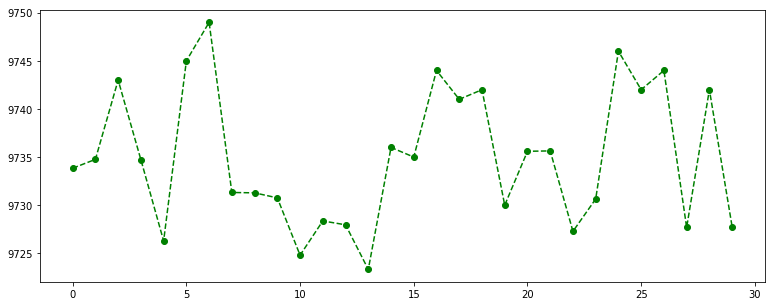

In [39]:
solution = []
acc = []
for loop in range(30):
    localSolution = []
    baat = bat(population,data_x,data_w,fmin,fmax,A,alpha,gamma)
    for i in range(epoch):
        baat.update_f()
        baat.update_v()
        baat.update_x()    
        baat.update_r()
        localSolution.append(np.max(baat.Y))
    solution.append(sum(localSolution)/len(localSolution))
    acc.append((sum(localSolution)/len(localSolution))/data_y)
averageSolution = sum(solution)/len(solution)
averageAcc = (sum(acc)/len(solution))*100
plt.figure(figsize=(13,5))
plt.plot(solution, "go--")
print ("with an average solution equal to",'%.3f' % averageSolution, " from ", data_y)
print ("Average accuracy equal to",'%.3f' % averageAcc, ' %')
plt.show()

